# Avaliação de Um Modelo de Redes Neurais Artificiais em Neonatologia
Projeto final da Disciplina de Aprendizagem de Máquina - PPgEEC/UFRN

### Notebook 2 - TREINAMENTO COM TENSORFLOW

## 1.  Configurações Iniciais

In [1]:
# Importação de módulos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.initializers

import wandb
import os
import logging

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Configuração dos gráficos
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True

In [3]:
# Carrega variáveis de ambiente
load_dotenv('config.env')
HASH_WANDB = os.getenv('HASH')

In [4]:
# Variáveis auxiliares
# Tamanho do conjunto de teste(fração do dataset que é utilizada como dados de teste)
val_size = 0.05

# Coeficiente de aleatoriedade
seed = 1618

# Variável alvo(target)
stratify = 'reanimacao'

# Artefato de entrada
input_artifact = 'mlprojfinal/df_rean.csv:latest'

# Tipo do artefato
artifact_type = 'TFTrain'

In [5]:
# Configurações de log
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# Objeto logging
logger = logging.getLogger()

In [28]:
# Função auxiliar para plotar os gráficos
def plotGraphics(modelo):

    medidas = pd.DataFrame(modelo.history.history)

    fig, ax = plt.subplots(2,2)
    sns.lineplot(data=[medidas.loss, medidas.val_loss], ax=ax[0][0])
    sns.lineplot(data=[medidas.accuracy, medidas.val_accuracy], ax=ax[0][1])
    sns.lineplot(data=[medidas[medidas.columns[3]], medidas[medidas.columns[7]]], ax=ax[1][0])
    sns.lineplot(data=[medidas[medidas.columns[2]], medidas[medidas.columns[6]]], ax=ax[1][1])
    plt.savefig(modelo.name, dpi=300)
    plt.show()

## 2. Aquisição do Artefato

In [7]:
# Login no wandb
!wandb login $HASH_WANDB --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


In [8]:
# Aquisição do artefato
run = wandb.init(project='mlprojfinal', job_type='tf_train')
artifact = run.use_artifact(input_artifact)
art_file = artifact.file()

wandb: Currently logged in as: ecalasans. Use `wandb login --relogin` to force relogin


In [9]:
# Transforma artefato em DataFrame
df = pd.read_csv(art_file)

In [10]:
df.shape

(503, 26)

In [11]:
# Retira coluna gerada no artefato
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [12]:
df.groupby(['reanimacao']).reanimacao.count()

reanimacao
0    294
1    209
Name: reanimacao, dtype: int64

In [13]:
entradas = df.shape[1] - 1

In [14]:
df.columns

Index(['fumo_n_fumo', 'fumo_s_fumo', 'alcool_n_alcool', 'alcool_s_alcool',
       'psicoativas_n_psico', 'psicoativas_s_psico', 'tpp_n_tpp', 'tpp_s_tpp',
       'dpp_n_dpp', 'dpp_s_dpp', 'oligoamnio_n_oligo', 'oligoamnio_s_oligo',
       'sifilis_n_sifilis', 'sifilis_s_sifilis', 'hiv_n_hiv', 'hiv_s_hiv',
       'covid_mae_n_covid', 'covid_mae_s_covid', 'dheg_n_dheg', 'dheg_s_dheg',
       'dm_n_dm', 'dm_s_dm', 'sexo_Masculino', 'idade_materna', 'reanimacao'],
      dtype='object')

## 3.  Divisão dos conjuntos de Treino e Teste

In [15]:
X = df.iloc[:,:-1].values

In [16]:
y = df['reanimacao'].values

In [17]:
X

array([[1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.24242424],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.27272727],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.12121212],
       ...,
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.57575758],
       [0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.45454545],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.33333333]])

In [18]:
y

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=seed)

## 4. Construção da Rede

Para a quantidade de camadas escondidas($H^{i}$) não há um consenso.  As estratégias variam entre experimentação, intuição, busca heurística, etc.

Dado que o número de camadas escondidas foi escolhido, o número de neurônios de cada uma delas também é escolhido de forma não consensual.  Algumas práticas adotadas são apontadas neste artigo:  [How to determine the number of layers and neurons in the hidden layer?](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3).

* Algum valor aleatório entre o tamanho da entrada e da saída;
* $\frac{2}{3}n_{entrada} + n_{saida}$;
* Menor que duas vezes o tamanho da entrada;

Usaremos, a princípio, duas camadas escondidas e a segunda regra para o número de neurônios de cada camada, por parecer mais determinística.

In [20]:
# Cálculo do número de neurônios das camadas escondidas
neuronios_hl = np.ceil(2/3 * entradas + 1)
neuronios_hl

17.0

In [21]:
# Criação do modelo
modelo_padrao = Sequential(name='modelo_padrao')
modelo_padrao.add(Dense(units=neuronios_hl, activation='relu'))
modelo_padrao.add(Dense(units=neuronios_hl, activation='relu'))
modelo_padrao.add(Dense(1, activation='sigmoid'))

2022-07-24 10:33:23.438192: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Compilação do modelo
modelo_padrao.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [24]:
modelo_padrao.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

2022-07-24 10:34:27.022125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [25]:
losses = pd.DataFrame(modelo_padrao.history.history)

In [26]:
losses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loss           300 non-null    float64
 1   accuracy       300 non-null    float64
 2   precision      300 non-null    float64
 3   recall         300 non-null    float64
 4   val_loss       300 non-null    float64
 5   val_accuracy   300 non-null    float64
 6   val_precision  300 non-null    float64
 7   val_recall     300 non-null    float64
dtypes: float64(8)
memory usage: 18.9 KB


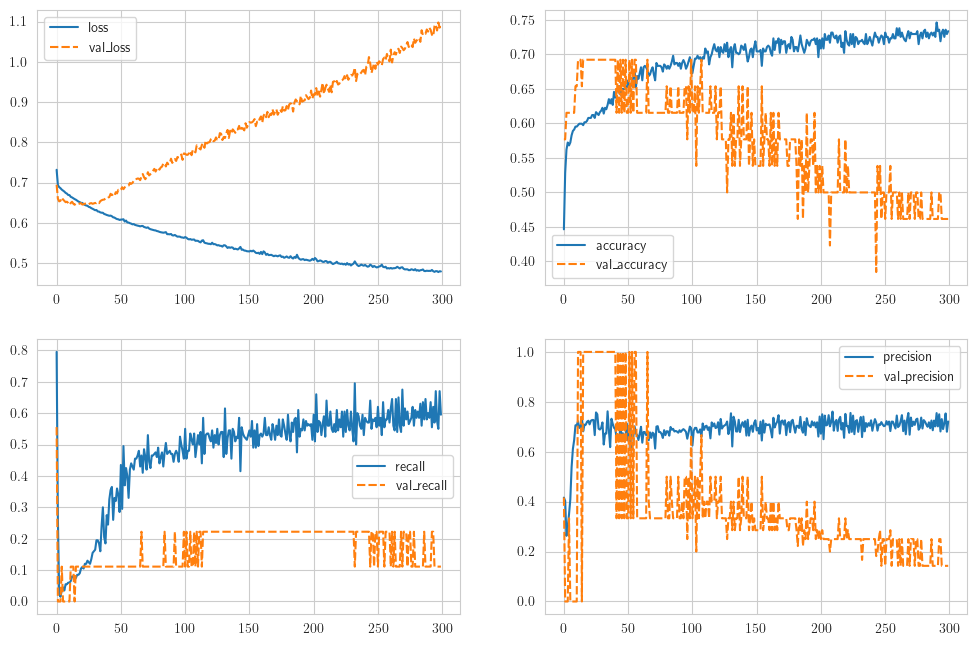

In [29]:
plotGraphics(modelo_padrao)

Vê-se claramente o problema do *overfitting*!  Agora serão aplicadas técnicas para tentar minimizar/corrigir tal situação.

## 5. Better Generalizing

### 5.1.  L2 Regularization

In [30]:
from tensorflow.keras.regularizers import l2

# Criação do modelo
modelo_l2 = Sequential(name='modelo_l2')
modelo_l2.add(Dense(units=neuronios_hl, activation='relu', kernel_regularizer=l2(0.001)))
modelo_l2.add(Dense(units=neuronios_hl, activation='relu', kernel_regularizer=l2(0.001)))
modelo_l2.add(Dense(1, activation='sigmoid'))

In [31]:
l2_precision = tf.keras.metrics.Precision()
l2_recall = tf.keras.metrics.Recall()

modelo_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', l2_precision, l2_recall])

In [32]:
modelo_l2.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

In [33]:
losses_l2 = pd.DataFrame(modelo_l2.history.history)

In [34]:
losses_l2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss             300 non-null    float64
 1   accuracy         300 non-null    float64
 2   precision_1      300 non-null    float64
 3   recall_1         300 non-null    float64
 4   val_loss         300 non-null    float64
 5   val_accuracy     300 non-null    float64
 6   val_precision_1  300 non-null    float64
 7   val_recall_1     300 non-null    float64
dtypes: float64(8)
memory usage: 18.9 KB


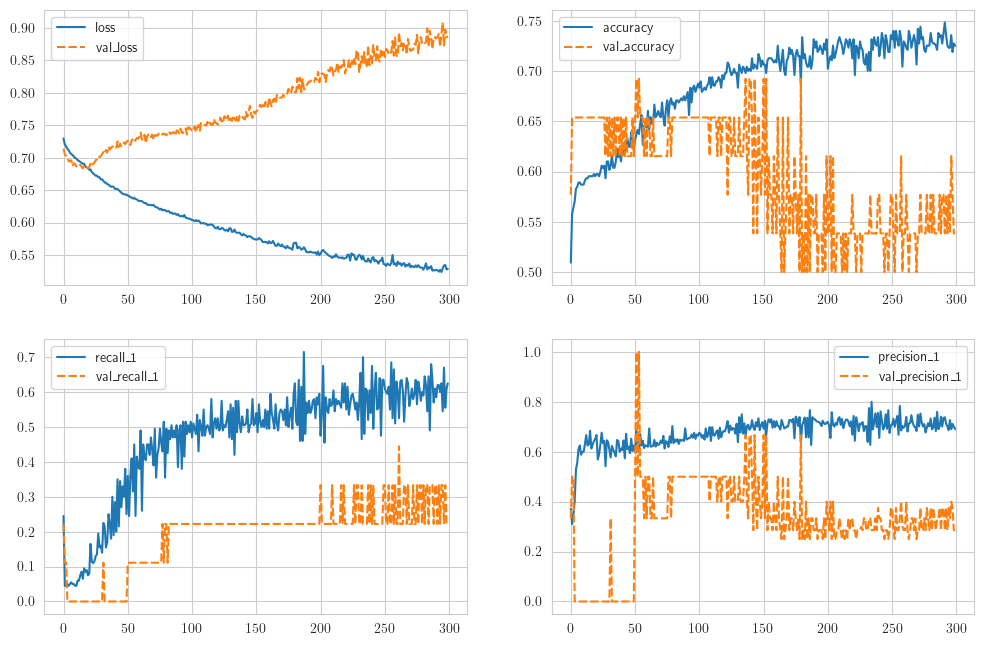

In [35]:
plotGraphics(modelo_l2)

### 5.2. Dropout

In [36]:
from tensorflow.keras.layers import Dropout

# Criação do modelo
modelo_dropout = Sequential(name='modelo_dropout')
modelo_dropout.add(Dense(units=neuronios_hl, activation='relu'))
modelo_dropout.add(Dropout(0.4))
modelo_dropout.add(Dense(units=neuronios_hl, activation='relu'))
modelo_dropout.add(Dropout(0.6))
modelo_dropout.add(Dense(1, activation='sigmoid'))

In [37]:
dropout_precision = tf.keras.metrics.Precision()
dropout_recall = tf.keras.metrics.Recall()

modelo_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dropout_precision, dropout_recall])

In [38]:
modelo_dropout.fit(x=X_train, y=y_train, epochs=300, verbose=0,validation_data=(X_test, y_test))

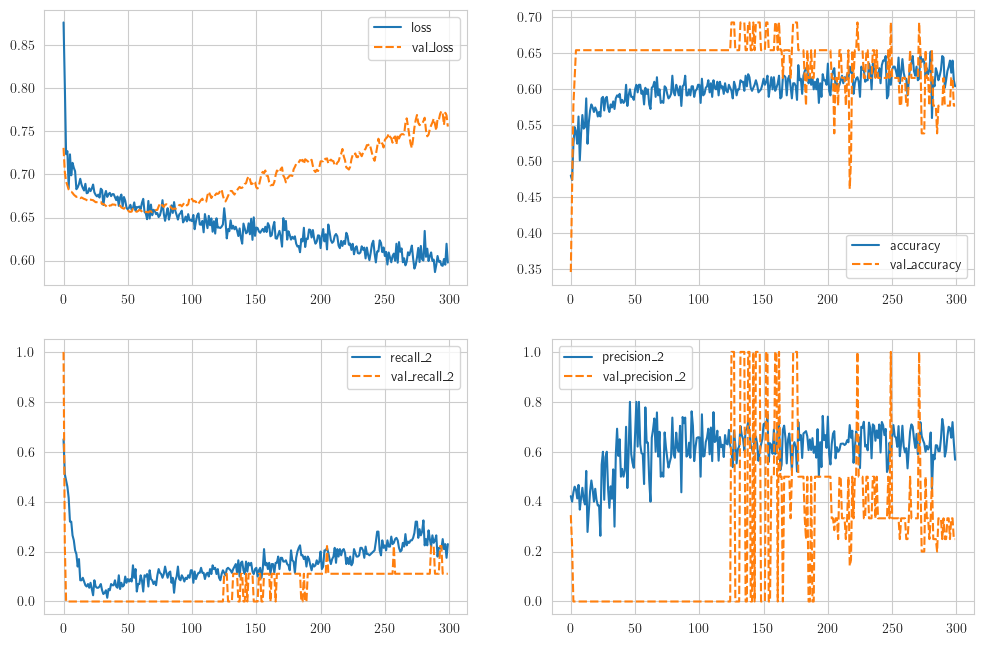

In [39]:
plotGraphics(modelo_dropout)

### 5.3. Restrição do Tamanho dos Pesos

### 5.3.1. unit_norm

In [40]:
from tensorflow.keras.constraints import unit_norm, min_max_norm

# Criação do modelo
modelo_unit_norm = Sequential(name='modelo_unit_norm')
modelo_unit_norm.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=unit_norm()))
modelo_unit_norm.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=unit_norm()))
modelo_unit_norm.add(Dense(1, activation='sigmoid'))

In [41]:
unit_norm_precision = tf.keras.metrics.Precision()
unit_norm_recall = tf.keras.metrics.Recall()

modelo_unit_norm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', unit_norm_precision, unit_norm_recall])

In [42]:
modelo_unit_norm.fit(x=X_train, y=y_train, epochs=300, verbose=0,validation_data=(X_test, y_test))

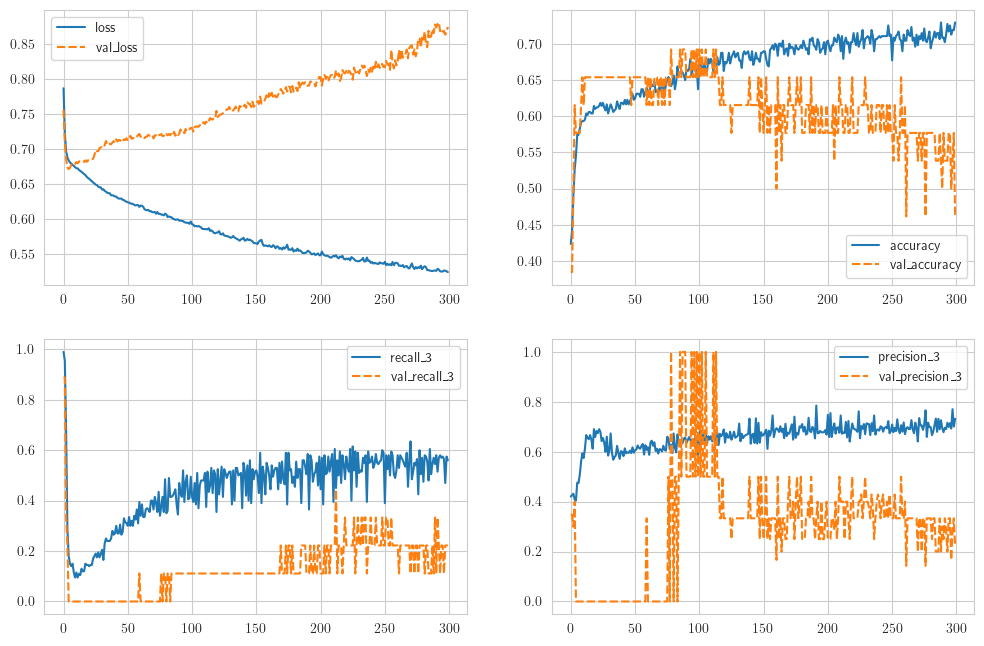

In [43]:
plotGraphics(modelo_unit_norm)

### 5.3.2. min_max_norm

In [44]:
# Criação do modelo
modelo_minmax = Sequential(name='modelo_minmax')
modelo_minmax.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=min_max_norm(min_value=0, max_value=2.0)))
modelo_minmax.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=min_max_norm(min_value=0, max_value=2.0)))
modelo_minmax.add(Dense(1, activation='sigmoid'))

In [45]:
minmax_precision = tf.keras.metrics.Precision()
minmax_recall = tf.keras.metrics.Recall()

modelo_minmax.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', minmax_precision, minmax_recall])

In [46]:
modelo_minmax.fit(X_train, y_train, epochs=300, verbose=0,validation_data=(X_test, y_test))

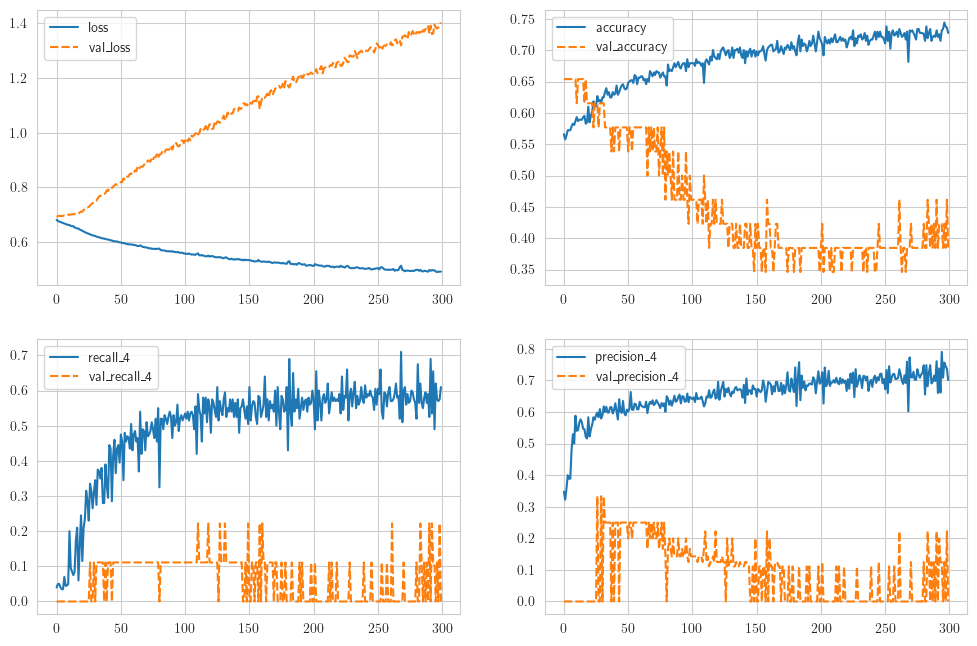

In [47]:
plotGraphics(modelo_minmax)

### 5.4.  Early Stopping

In [72]:
# Criação do modelo
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

modelo_es = Sequential(name='modelo_es')
modelo_es.add(Dense(units=neuronios_hl, activation='relu'))
modelo_es.add(Dense(units=neuronios_hl, activation='relu'))
modelo_es.add(Dense(1, activation='sigmoid'))

In [73]:
es_precision = tf.keras.metrics.Precision(name='es_precision')
es_recall = tf.keras.metrics.Recall(name='es_recall')

In [74]:
es = EarlyStopping(monitor=es_precision.name, mode='max', patience=50, verbose=1)
#mc = ModelCheckpoint('best_model.h5', monitor=es_precision.name, mode='max', verbose=1, save_best_only=True)

In [75]:
modelo_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', es_precision, es_recall])

In [76]:
modelo_es.fit(x=X_train, y=y_train, epochs=300, verbose=0,validation_data=(X_test, y_test), callbacks=[es])

Epoch 00089: early stopping


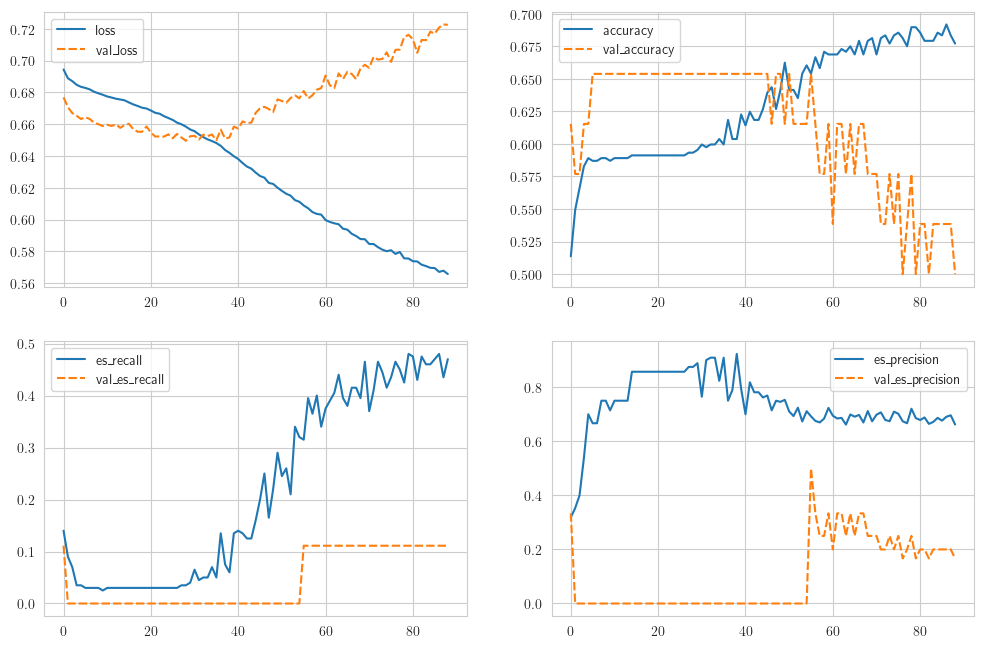

In [77]:
plotGraphics(modelo_es)

In [84]:
es_precision.result().numpy()

0.16666667

---

## 6. Better Learning

Nesta seção aplicaremos os conhecimentos da seção *Better Learning* no *dataset*.

### 6.1.  Inicialização dos Pesos

### 6.1.1.  Inicialização com zeros

In [85]:
#  Criação dos modelo
zeros = tf.keras.initializers.Zeros()

modelo_zeros = Sequential(name='modelo_zeros')
modelo_zeros.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=zeros))
modelo_zeros.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=zeros))
modelo_zeros.add(Dense(1, activation='sigmoid'))

In [86]:
z_precision = tf.keras.metrics.Precision(name='z_precision')
z_recall = tf.keras.metrics.Recall(name='z_recall')

In [87]:
modelo_zeros.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', z_precision, z_recall])

In [88]:
modelo_zeros.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

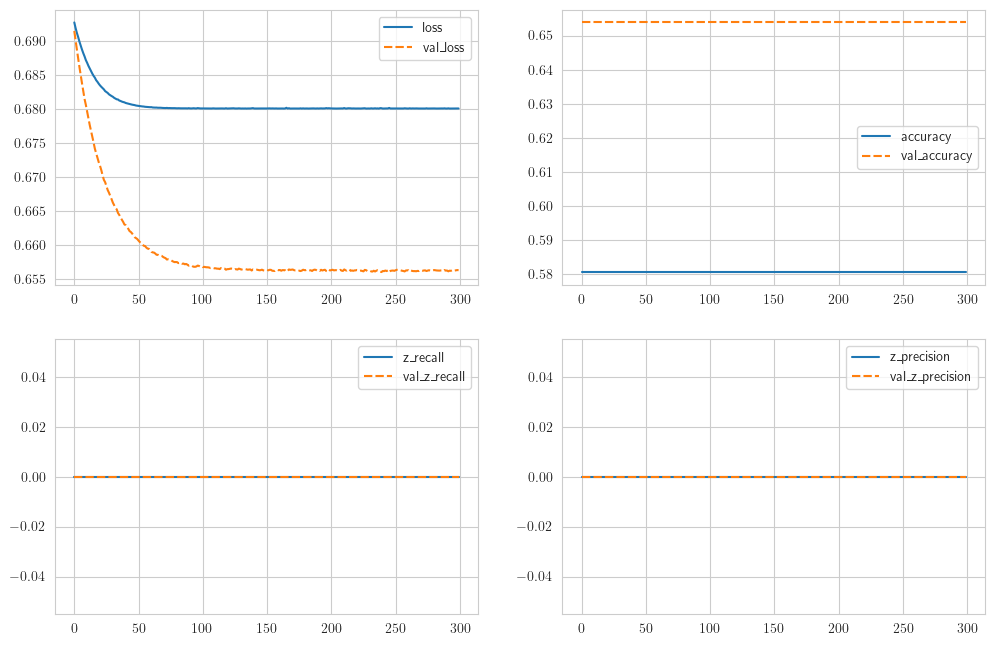

In [89]:
plotGraphics(modelo_zeros)

### 6.1.2.  Inicialização Aleatória

In [100]:
#  Criação do Modelo
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

modelo_alea = Sequential(name='modelo_alea')
modelo_alea.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))
modelo_alea.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))
modelo_alea.add(Dense(1, activation='sigmoid'))

In [101]:
alea_precision = tf.keras.metrics.Precision(name='alea_precision')
alea_recall = tf.keras.metrics.Recall(name='alea_recall')

In [102]:
modelo_alea.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', alea_precision, alea_recall])

In [97]:
modelo_alea.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

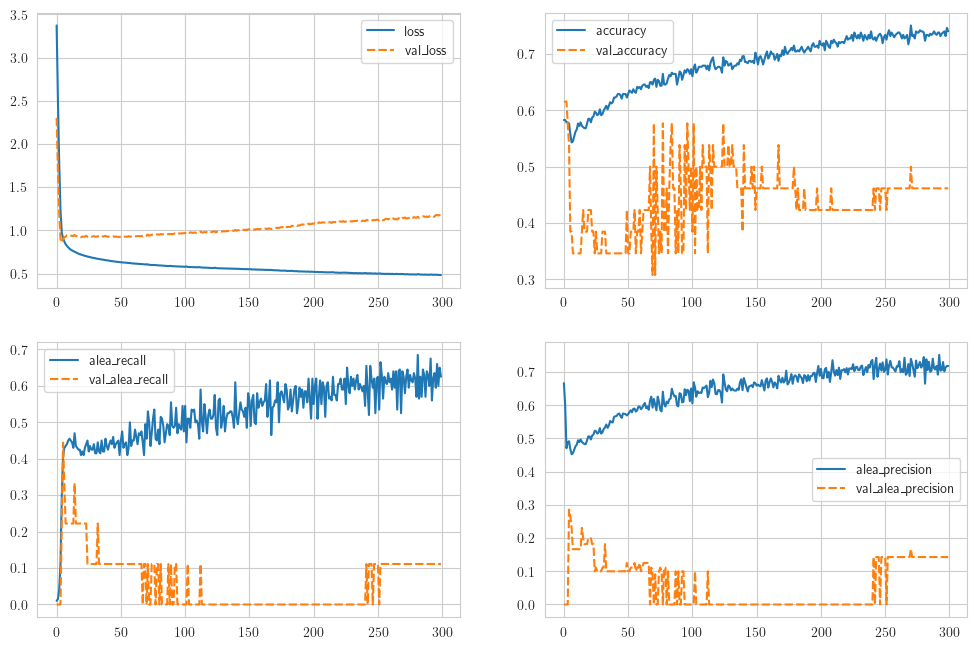

In [98]:
plotGraphics(modelo_alea)

Pela primera vez observamos *Underfitting* com posterior melhora de aprendizagem.  O que acontece com o aumento das épocas?  Melhora a acurácia do modelo???

Podemos combinar esta técnica com o **Early Stopping**.

In [99]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_recall = EarlyStopping(monitor=alea_precision.name, mode='max', patience=30, verbose=0)

In [103]:
modelo_alea.fit(x=X_train, y=y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping_recall])

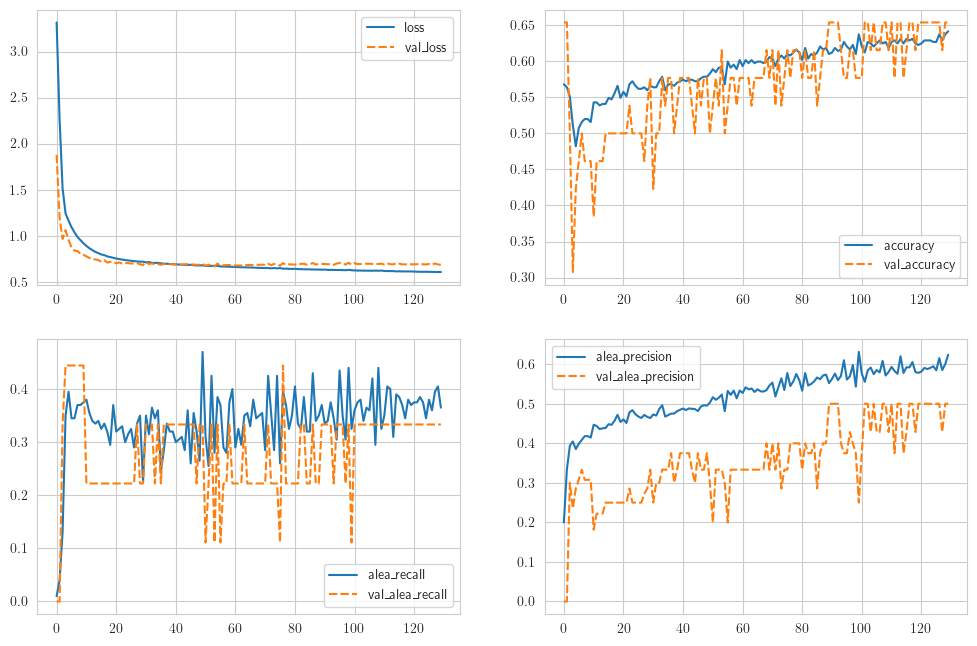

In [104]:
plotGraphics(modelo_alea)

## 7.  Batch Normalization

Conforme visto, o *batch normalization* pode ser aplicado **antes** da função de ativação, **depois** da função de ativação ou, ainda, **nas entradas**.  Vamos investigar cada situação destas a seguir.

### 7.1.  Antes da Função de Ativação

Dos modelos anteriores, a melhor performance foi obtida inicializando-se os pesos aleatoriamente.  Desta forma utilizaremos esta técnica combinada com o *batch normalization*.

In [138]:
from tensorflow.keras.layers import BatchNormalization, Activation

In [106]:
bn_before_precision = tf.keras.metrics.Precision(name='bn_before_precision')
bn_before_recall = tf.keras.metrics.Recall(name='bn_before_recall')

In [107]:
#  Criação do Modelo
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

modelo_bn_before = Sequential(name='modelo_bn_before')
modelo_bn_before.add(Dense(units=neuronios_hl, kernel_initializer=alea))
modelo_bn_before.add(tf.keras.layers.BatchNormalization())
modelo_bn_before.add(tf.keras.layers.Activation(tf.nn.relu))

modelo_bn_before.add(Dense(units=neuronios_hl, kernel_initializer=alea))
modelo_bn_before.add(tf.keras.layers.BatchNormalization())
modelo_bn_before.add(tf.keras.layers.Activation(tf.nn.relu))

modelo_bn_before.add(Dense(1, activation='sigmoid'))

In [108]:
modelo_bn_before.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', bn_before_precision, bn_before_recall])

In [109]:
modelo_bn_before.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

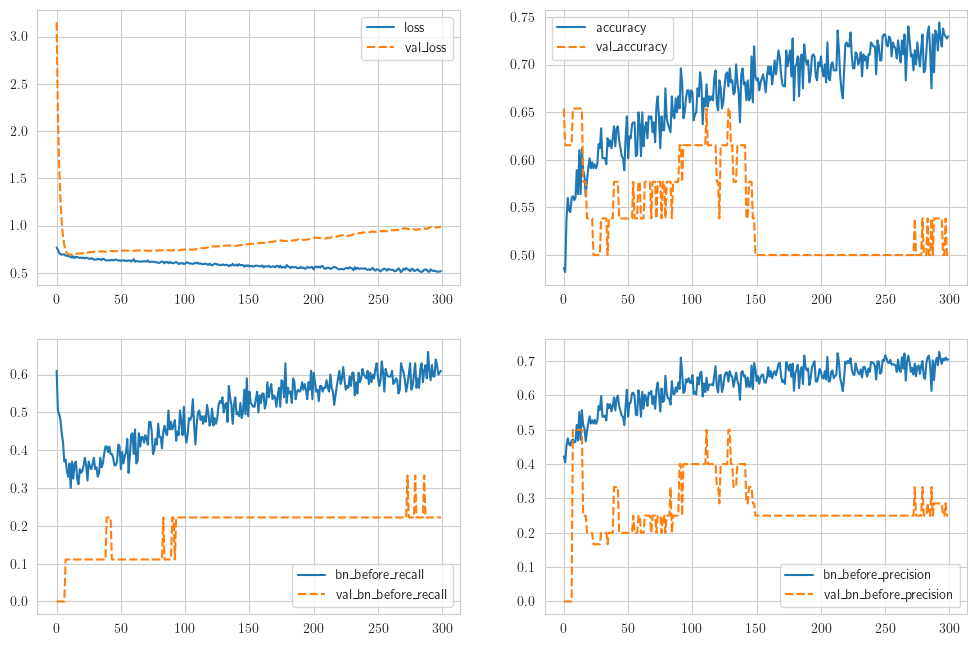

In [110]:
plotGraphics(modelo_bn_before)

### 7.2.  Depois da Função de Ativação

In [111]:
bn_after_precision = tf.keras.metrics.Precision(name='bn_after_precision')
bn_after_recall = tf.keras.metrics.Recall(name='bn_after_recall')

In [112]:
#  Criação do Modelo
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

modelo_bn_after = Sequential(name='modelo_bn_after')
modelo_bn_after.add(Dense(units=neuronios_hl, kernel_initializer=alea))
modelo_bn_after.add(tf.keras.layers.Activation(tf.nn.relu))
modelo_bn_after.add(tf.keras.layers.BatchNormalization())

modelo_bn_after.add(Dense(units=neuronios_hl, kernel_initializer=alea))
modelo_bn_after.add(tf.keras.layers.Activation(tf.nn.relu))
modelo_bn_after.add(tf.keras.layers.BatchNormalization())

modelo_bn_after.add(Dense(1, activation='sigmoid'))

In [113]:
modelo_bn_after.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', bn_after_precision, bn_after_recall])

In [114]:
modelo_bn_after.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

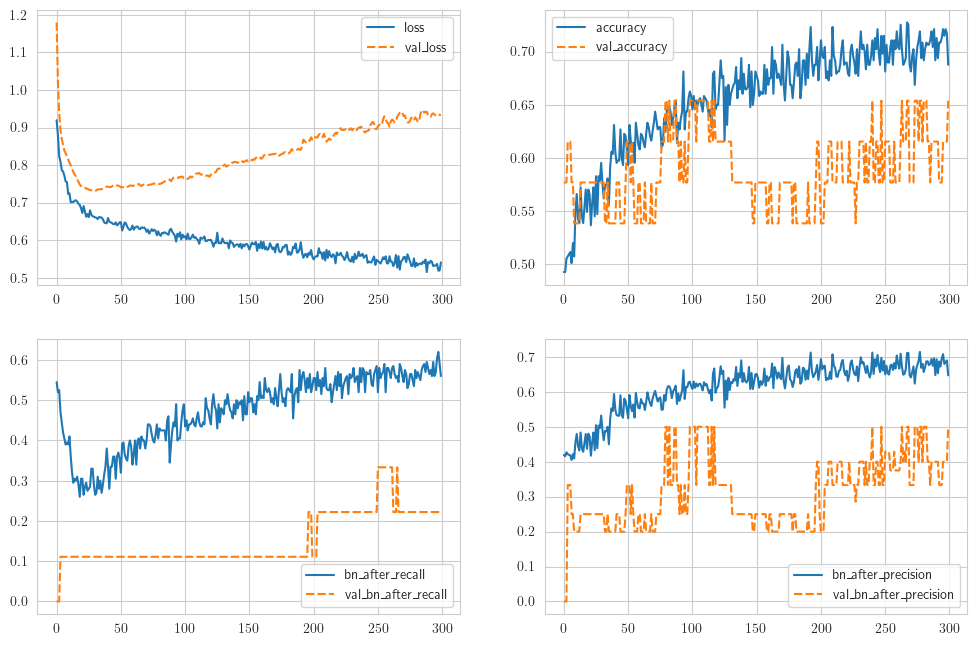

In [115]:
plotGraphics(modelo_bn_after)

### 7.3. Entradas

In [116]:
entradas_precision = tf.keras.metrics.Precision(name='entradas_precision')
entradas_recall = tf.keras.metrics.Recall(name='entradas_recall')

In [117]:
#  Criação do Modelo
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

modelo_bn_entrada = Sequential(name='modelo_bn_entrada')
modelo_bn_entrada.add(tf.keras.layers.BatchNormalization(input_shape=(24,)))
modelo_bn_entrada.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))
modelo_bn_entrada.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))

modelo_bn_entrada.add(Dense(1, activation='sigmoid'))

In [118]:
modelo_bn_entrada.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', entradas_precision, entradas_recall])

In [119]:
modelo_bn_entrada.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

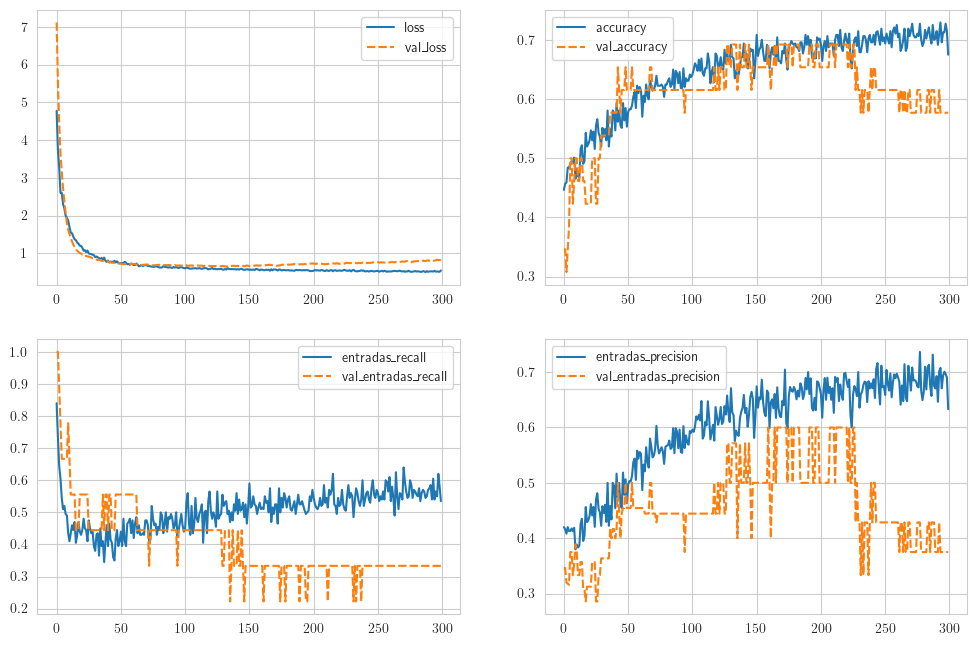

In [120]:
plotGraphics(modelo_bn_entrada)

## 8. Ajuste de Hiperparâmetros com Wandb

Vamos usar o **Sweeps** do wandb para avaliar a melhor configuração baseada na *precision*.

In [159]:
wandb.finish()

In [123]:
# Função para o Sweeps
def train():
    #  Parâmetros de configuração
    config_defaults = {
        'hidden1': neuronios_hl,
        'hidden2': neuronios_hl,
        'learn_rate': 0.001,
        'batch_size': 32,
        'epochs': 300,
    }

    alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

    #  Inicia novo projeto
    wandb.init(project='final_sweeps', config=config_defaults)

    # Parâmetros de configuração
    config_wb = wandb.config

    #  Criação do modelo
    modelo_sweeps = Sequential()
    modelo_sweeps.add(tf.keras.layers.BatchNormalization(input_shape=(24,)))
    modelo_sweeps.add(Dense(units=config_wb.hidden1, activation='relu', kernel_initializer=alea))
    modelo_sweeps.add(Dense(units=config_wb.hidden2, activation='relu', kernel_initializer=alea))
    modelo_sweeps.add(Dense(units=1, activation='sigmoid'))

    #  Métricas
    wb_accuracy = tf.keras.metrics.Accuracy(name='wb_accuracy')
    wb_precision = tf.keras.metrics.Precision(name='wb_precision')
    wb_recall = tf.keras.metrics.Recall(name='wb_recall')

    #  Compilação
    wb_optimizer = tf.keras.optimizers.Adam()
    wb_loss = tf.keras.losses.BinaryCrossentropy()

    modelo_sweeps.compile(optimizer=wb_optimizer, loss=wb_loss, metrics=[wb_accuracy, wb_precision, wb_recall])

    #  Treinamento
    modelo_sweeps.fit(x=X_train, y=y_train,
                      batch_size=config_wb.batch_size,
                      epochs=config_wb.epochs,
                      verbose=0,
                      validation_data=(X_train, y_train))

    wandb.log({"wb_precision": wb_precision.result()})


In [122]:
#  Configuração do Sweeps
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
wandb.log({"alea": alea})
sweep_config = {
    # Método de inicialização das execuções
    'method': 'random',

    # Métrica a ser otimizada
    'metric': {
        'name': 'wb_precision',
        'goal': 'maximize'
    },

    # Hiperparâmetros a serem combinados
    'parameters': {
        #  Número de neurônios da primeira camada escondida
        'hidden1':{
            'max': 17,
            'min': 10,
            'distribution': 'int_uniform'
        },

        #  Número de neurônios da segunda camada escondida
        'hidden2':{
            'max': 17,
            'min': 10,
            'distribution': 'int_uniform'
        },

        #  Tamanho do mini-batch(tamanho do conjunto de dados processados por vez até
        # completar a época)
        'batch_size': {
            'values': [8,16,32,64]
        },

        #  Modo de inicialização dos pesos
        'kernel_initializers': {
            'values': ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal', 'ones', 'alea']
        }

    }
}

In [124]:
sweep_id = wandb.sweep(sweep=sweep_config, entity='ecalasans', project='mlprojfinal')

Create sweep with ID: n02dqg77
Sweep URL: https://wandb.ai/ecalasans/mlprojfinal/sweeps/n02dqg77


In [125]:
wandb.agent(sweep_id=sweep_id, function=train, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: hvzojfq5 with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 17
wandb: 	hidden2: 10
wandb: 	kernel_initializers: ones
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.73793


wandb: Agent Starting Run: oixgqfup with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 15
wandb: 	hidden2: 15
wandb: 	kernel_initializers: ones
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.71508


wandb: Agent Starting Run: 3jezn9fh with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 11
wandb: 	hidden2: 16
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.73203


wandb: Agent Starting Run: va8sgm0a with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 12
wandb: 	hidden2: 13
wandb: 	kernel_initializers: glorot_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.75


wandb: Agent Starting Run: 01ayagxu with config:
wandb: 	batch_size: 64
wandb: 	hidden1: 11
wandb: 	hidden2: 13
wandb: 	kernel_initializers: glorot_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.67598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ob6ir8au with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 10
wandb: 	hidden2: 14
wandb: 	kernel_initializers: glorot_uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.68862


wandb: Agent Starting Run: p2umml1n with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 11
wandb: 	hidden2: 13
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.68841


wandb: Agent Starting Run: xv4lbxct with config:
wandb: 	batch_size: 8
wandb: 	hidden1: 13
wandb: 	hidden2: 16
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.66667


wandb: Agent Starting Run: y8343i6v with config:
wandb: 	batch_size: 8
wandb: 	hidden1: 11
wandb: 	hidden2: 14
wandb: 	kernel_initializers: he_uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.70861


wandb: Agent Starting Run: 6x7e8eps with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 10
wandb: 	hidden2: 12
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.68354


wandb: Agent Starting Run: 763tzn1a with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 11
wandb: 	hidden2: 17
wandb: 	kernel_initializers: ones
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8c78z7sx with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 11
wandb: 	hidden2: 11
wandb: 	kernel_initializers: alea
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.73684


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ciislj9 with config:
wandb: 	batch_size: 8
wandb: 	hidden1: 10
wandb: 	hidden2: 17
wandb: 	kernel_initializers: alea
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.65248


wandb: Agent Starting Run: 78srik9q with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 13
wandb: 	hidden2: 10
wandb: 	kernel_initializers: ones
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.6875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w8ccv9j0 with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 16
wandb: 	hidden2: 13
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.75172


wandb: Agent Starting Run: ssjvoebf with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 11
wandb: 	hidden2: 11
wandb: 	kernel_initializers: glorot_uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.70455


wandb: Agent Starting Run: 1u4m09rr with config:
wandb: 	batch_size: 64
wandb: 	hidden1: 13
wandb: 	hidden2: 15
wandb: 	kernel_initializers: he_uniform
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.72956


wandb: Agent Starting Run: 55gkitwm with config:
wandb: 	batch_size: 8
wandb: 	hidden1: 12
wandb: 	hidden2: 15
wandb: 	kernel_initializers: alea
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.68421


wandb: Agent Starting Run: fn8ysqzg with config:
wandb: 	batch_size: 16
wandb: 	hidden1: 17
wandb: 	hidden2: 13
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.72258


wandb: Agent Starting Run: 4n4nk1bv with config:
wandb: 	batch_size: 32
wandb: 	hidden1: 15
wandb: 	hidden2: 12
wandb: 	kernel_initializers: he_normal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wb_precision,▁
wb_precision,0.71069


In [25]:
wandb.finish()